# Breast Cancer Classification with Logistic Regression and Neural Networks  

**Objective**:  
This notebook demonstrates how to classify breast cancer tumors as benign (0) or malignant (1) using:  
1. **Logistic Regression** (from scratch using PyTorch)  
2. **A Simple Neural Network** (built with PyTorch)  

**Dataset**:  
The [Breast Cancer Wisconsin (Diagnostic) Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) contains features computed from digitized images of breast mass biopsies.  
- **Features**: `clump_thickness`, `uniformity_cell_size`, etc.  
- **Target**: `class` (2 = benign, 4 = malignant → mapped to 0 and 1).  

### Data Exploration  
- **Missing Values**: We check for missing data (like the `bare_nuclei` column with '?' entries).  
- **Class Balance**: Visualizing the target variable to check for imbalance.  

In [1]:
import pandas as pd

# Load the dataset from UCI archive
column_names = [
    'id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

df = pd.read_csv(url, names=column_names)
df.head()


,id,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Missing values:
 id                             0
clump_thickness                0
uniformity_cell_size           0
uniformity_cell_shape          0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
class                          0
dtype: int64


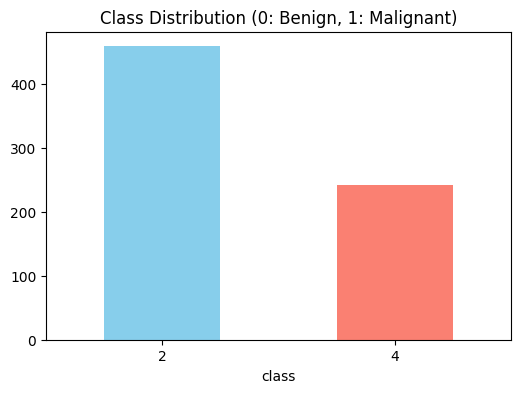

In [2]:
# Check for missing values
print("Missing values:\n", df.isna().sum())

# Visualize class distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
df['class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution (0: Benign, 1: Malignant)")
plt.xticks(rotation=0)
plt.show()

In [3]:
df.describe(include=[object])


,bare_nuclei
count,699
unique,11
top,1
freq,402


### Data Preprocessing  
1. **Handling Missing Values**: The `bare_nuclei` column had '?' entries, replaced with the mode (most frequent value).  
2. **Normalization**: Features are standardized (mean=0, std=1) to help models converge faster.  

In [4]:
most_common = df['bare_nuclei'].mode()[0]
df['bare_nuclei'] = df['bare_nuclei'].replace('?', most_common)

In [5]:
df['bare_nuclei'] = df['bare_nuclei'].astype(float)

In [6]:
import numpy as np

df.describe(include=(np.number))

,id,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


**Map class labels: 2 → 0 (benign), 4 → 1 (malignant)**

In [7]:
df['class'] = df['class'].map({2: 0, 4: 1})

**Split features (X) and target (y)**

In [8]:
X = df.drop(['id', 'class'], axis=1).values
y = df['class'].values

In [9]:
df.dtypes

id                               int64
clump_thickness                  int64
uniformity_cell_size             int64
uniformity_cell_shape            int64
marginal_adhesion                int64
single_epithelial_cell_size      int64
bare_nuclei                    float64
bland_chromatin                  int64
normal_nucleoli                  int64
mitoses                          int64
class                            int64
dtype: object

In [10]:
# Standard normalization
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [11]:
from sklearn.model_selection import train_test_split

# Split into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

Train: (419, 9), Valid: (140, 9), Test: (140, 9)


In [12]:
import torch
import torch.nn as nn

# Convert data to PyTorch tensors (using your X_train/X_valid split)
t_indep = torch.tensor(X_train, dtype=torch.float)
t_dep = torch.tensor(y_train, dtype=torch.float).unsqueeze(1)  # Shape (n, 1)
t_valid_indep = torch.tensor(X_valid, dtype=torch.float)
t_valid_dep = torch.tensor(y_valid, dtype=torch.float).unsqueeze(1)

In [13]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [14]:
# Initialize model
model = LogisticRegression(in_features=X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [15]:
# Training loop with validation
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(t_indep)
    loss = criterion(outputs, t_dep)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(t_valid_indep)
        val_loss = criterion(val_outputs, t_valid_dep)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 000 | Train Loss: 0.5654 | Val Loss: 0.4883
Epoch 010 | Train Loss: 0.2662 | Val Loss: 0.2388
Epoch 020 | Train Loss: 0.1969 | Val Loss: 0.1790
Epoch 030 | Train Loss: 0.1667 | Val Loss: 0.1534
Epoch 040 | Train Loss: 0.1499 | Val Loss: 0.1395
Epoch 050 | Train Loss: 0.1393 | Val Loss: 0.1310
Epoch 060 | Train Loss: 0.1319 | Val Loss: 0.1253
Epoch 070 | Train Loss: 0.1266 | Val Loss: 0.1212
Epoch 080 | Train Loss: 0.1225 | Val Loss: 0.1182
Epoch 090 | Train Loss: 0.1192 | Val Loss: 0.1159


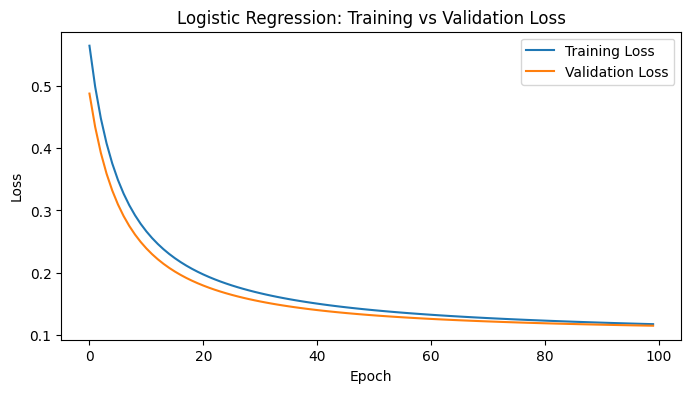

In [16]:
# Plot losses
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Logistic Regression: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
class Net(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 4)  # Hidden layer with 4 neurons
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)            # Output layer
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))

In [18]:
# Initialize network
net = Net(in_features=X_train.shape[1])
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [19]:
# Training loop
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training
    net.train()
    optimizer.zero_grad()
    preds = net(t_indep)
    loss = criterion(preds, t_dep)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    net.eval()
    with torch.no_grad():
        val_preds = net(t_valid_indep)
        val_loss = criterion(val_preds, t_valid_dep)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 000 | Train Loss: 0.7295 | Val Loss: 0.7407
Epoch 010 | Train Loss: 0.6417 | Val Loss: 0.6541
Epoch 020 | Train Loss: 0.5730 | Val Loss: 0.5847
Epoch 030 | Train Loss: 0.4892 | Val Loss: 0.4961
Epoch 040 | Train Loss: 0.3903 | Val Loss: 0.3881
Epoch 050 | Train Loss: 0.2868 | Val Loss: 0.2761
Epoch 060 | Train Loss: 0.2084 | Val Loss: 0.1963
Epoch 070 | Train Loss: 0.1637 | Val Loss: 0.1538
Epoch 080 | Train Loss: 0.1395 | Val Loss: 0.1322
Epoch 090 | Train Loss: 0.1254 | Val Loss: 0.1204


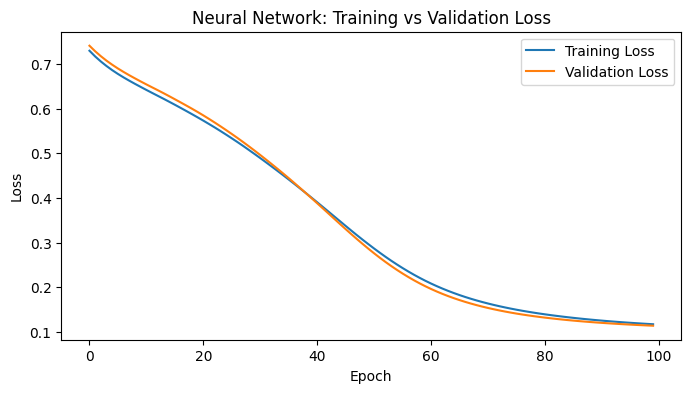

In [20]:
# Plot losses
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Neural Network: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, X, y, model_name):
    # Convert data to tensor
    X_tensor = torch.tensor(X, dtype=torch.float)
    model.eval()
    
    with torch.no_grad():
        # Get predictions and convert to binary (0 or 1)
        preds = (model(X_tensor) > 0.5).float().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    cm = confusion_matrix(y, preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'], 
                yticklabels=['Benign', 'Malignant'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, precision, recall, cm

Logistic Regression Performance:


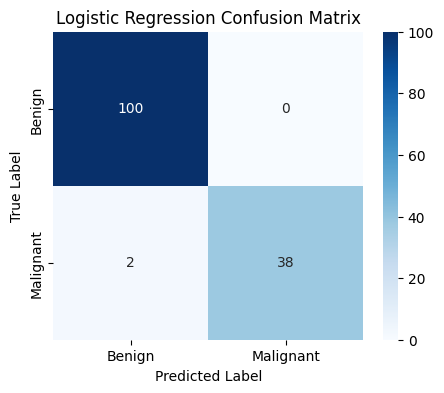

Accuracy:  0.9857
Precision: 1.0000
Recall:    0.9500

Neural Network Performance:


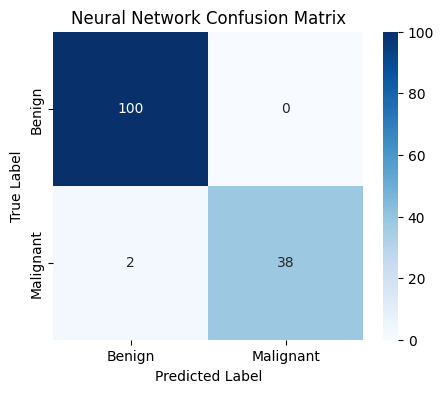

Accuracy:  0.9857
Precision: 1.0000
Recall:    0.9500


In [22]:
# Evaluate on TEST set (using your existing X_valid/X_test split)
print("="*50)
print("Logistic Regression Performance:")
lr_accuracy, lr_precision, lr_recall, lr_cm = evaluate_model(model, X_test, y_test, "Logistic Regression")
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")

print("\n" + "="*50)
print("Neural Network Performance:")
nn_accuracy, nn_precision, nn_recall, nn_cm = evaluate_model(net, X_test, y_test, "Neural Network")
print(f"Accuracy:  {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall:    {nn_recall:.4f}")